<h2>Pré-processamento das Imagens</h2>

<p>Essa célula carrega a imagem em escala de cinza utilizando a biblioteca OpenCV (cv2). Em seguida, exibe a imagem utilizando o matplotlib, que nos permite visualizar a imagem original antes de qualquer processamento.</p>

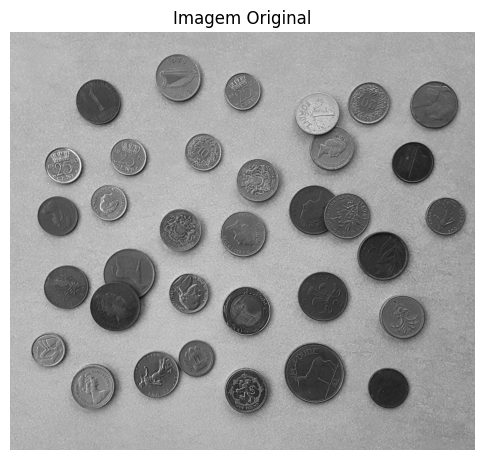

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Carregando a imagem em escala de cinza
image_path = 'coins-01.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Exibindo a imagem original
plt.figure(figsize=(6, 6))
plt.title("Imagem Original")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()


<P>Aqui, aplicamos um filtro de borrão Gaussiano (GaussianBlur) para suavizar a imagem e reduzir ruídos que poderiam atrapalhar a detecção de bordas.</p>

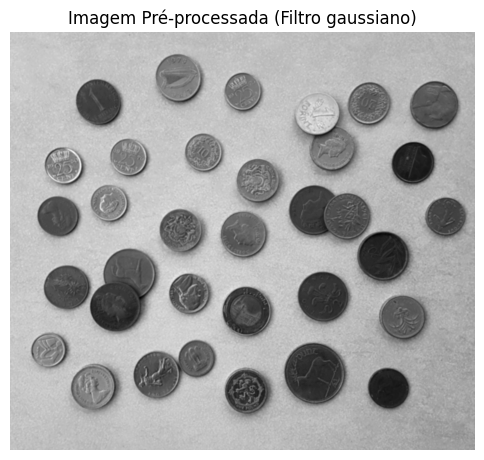

In [3]:
# Aplicar um filtro de borrão para suavizar a imagem
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# Exibindo a imagem pré-processada
plt.figure(figsize=(6, 6))
plt.title("Imagem Pré-processada (Filtro gaussiano)")
plt.imshow(blurred_image, cmap='gray')
plt.axis('off')
plt.show()


<h2>Extração do Fundo</h2>

<p>Nesta célula, utilizamos o algoritmo Canny para detectar as bordas da imagem. Após isso, realizamos uma dilatação manual das bordas para preencher pequenas lacunas e conectar pedaços desconectados. A dilatação ajuda a tornar os objetos mais completos para que possam ser rotulados corretamente.</p>

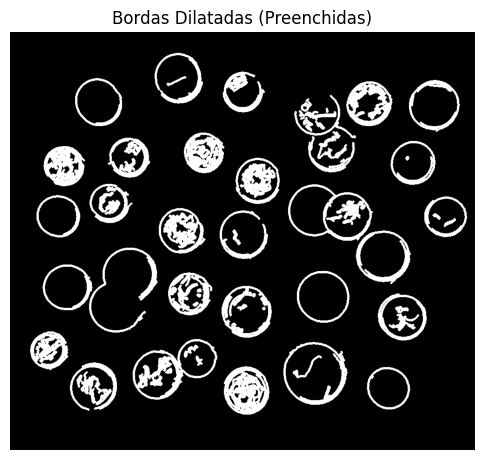

In [4]:
# Aplicar a detecção de bordas
edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)

# Dilatação manual para preencher pequenas lacunas entre as bordas
def dilate(image, iterations= 5):
    rows, cols = image.shape
    new_image = np.copy(image)
    
    for _ in range(iterations):
        for i in range(1, rows-1):
            for j in range(1, cols-1):
                if image[i, j] == 255:
                    # Preencher pixels vizinhos
                    new_image[i+1, j] = 255
                    new_image[i-1, j] = 255
                    new_image[i, j+1] = 255
                    new_image[i, j-1] = 255
        image = np.copy(new_image)
    return new_image

# Dilatar as bordas para conectar pequenos pedaços
dilated_edges = dilate(edges, iterations=2)

# Exibir as bordas dilatadas
plt.figure(figsize=(6, 6))
plt.title("Bordas Dilatadas (Preenchidas)")
plt.imshow(dilated_edges, cmap='gray')
plt.axis('off')
plt.show()


<h2>Segmentação e Contagem de Objetos usando Flood Fill</h2>

<p>Aqui, a função bfs (Busca em Largura) rotula cada objeto conectado na imagem, atribuindo um número de rótulo único a cada um deles. Depois, pequenos objetos (aqueles cuja área é menor que area_threshold) são excluídos, resultando apenas nos objetos relevantes. O número final de objetos detectados é exibido junto com uma imagem segmentada que mostra esses objetos rotulados.</p>

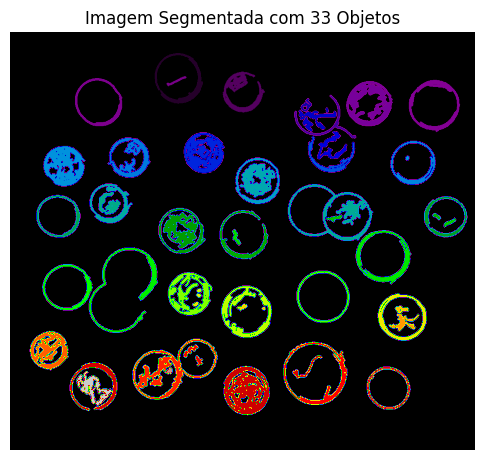

In [5]:
# Inicializando a matriz de rótulos
label_count = 1
labels = np.zeros_like(dilated_edges, dtype=np.int32)
rows, cols = dilated_edges.shape

# BFS para detectar objetos conectados
def bfs(x, y, label):
    queue = [(x, y)]
    labels[x, y] = label
    while queue:
        cx, cy = queue.pop(0)
        for nx, ny in [(cx+1, cy), (cx-1, cy), (cx, cy+1), (cx, cy-1)]:
            if 0 <= nx < rows and 0 <= ny < cols:
                if dilated_edges[nx, ny] == 255 and labels[nx, ny] == 0:
                    labels[nx, ny] = label
                    queue.append((nx, ny))

# Rotular os objetos conectados
for i in range(rows):
    for j in range(cols):
        if dilated_edges[i, j] == 255 and labels[i, j] == 0:
            bfs(i, j, label_count)
            label_count += 1

# Excluir objetos pequenos (menores que uma área mínima)
area_threshold = 1300  # Define o limite de área para considerar um objeto válido
filtered_labels = np.copy(labels)
for label in range(1, label_count):
    area = np.sum(labels == label)
    if area < area_threshold:
        filtered_labels[labels == label] = 0

# Recontar os objetos após filtrar pequenos fragmentos
unique_labels = np.unique(filtered_labels)
num_objects = len(unique_labels) - 1  # Exclui o rótulo 0 (fundo)


# Exibir a imagem com os objetos rotulados
plt.figure(figsize=(6, 6))
plt.title(f"Imagem Segmentada com {num_objects} Objetos")
plt.imshow(labels, cmap='nipy_spectral')
plt.axis('off')
plt.show()



<h2>Visualização e Cálculo da Área dos Objetos</h2>

<p>Nesta última parte, criamos uma representação colorida dos objetos segmentados usando o espaço de cor HSV, onde cada objeto recebe uma tonalidade (hue) diferente. A imagem resultante é exibida, e a área de cada objeto segmentado é calculada e mostrada</p>

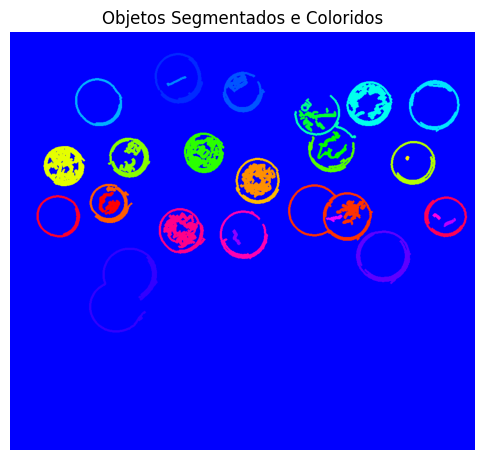

Objeto 1: 2338 pixels
Objeto 2: 2896 pixels
Objeto 3: 228 pixels
Objeto 4: 1713 pixels
Objeto 5: 2510 pixels
Objeto 6: 4906 pixels
Objeto 7: 1201 pixels
Objeto 8: 335 pixels
Objeto 9: 53 pixels
Objeto 10: 1407 pixels
Objeto 11: 1267 pixels
Objeto 12: 5110 pixels
Objeto 13: 1595 pixels
Objeto 14: 3475 pixels
Objeto 15: 1962 pixels
Objeto 16: 5102 pixels
Objeto 17: 65 pixels
Objeto 18: 1725 pixels
Objeto 19: 3400 pixels
Objeto 20: 2065 pixels
Objeto 21: 4807 pixels
Objeto 22: 1213 pixels
Objeto 23: 1553 pixels
Objeto 24: 1717 pixels
Objeto 25: 5062 pixels
Objeto 26: 2060 pixels
Objeto 27: 133 pixels
Objeto 28: 255 pixels
Objeto 29: 201 pixels
Objeto 30: 276 pixels
Objeto 31: 2977 pixels
Objeto 32: 3060 pixels
Objeto 33: 1805 pixels


In [6]:
# Criar a imagem colorida no espaço HSV para cada objeto (implementado manualmente)
hue_img = np.zeros_like(labels, dtype=np.uint8)
saturation = np.ones_like(labels, dtype=np.uint8) * 255
value = np.ones_like(labels, dtype=np.uint8) * 255

for i in range(1, num_objects + 1):
    hue_value = int(180 * (i / num_objects))
    for x in range(rows):
        for y in range(cols):
            if labels[x, y] == i:
                hue_img[x, y] = hue_value

# Convertendo para RGB
hsv_img = cv2.merge([hue_img, saturation, value])
color_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)

# Exibindo a imagem colorida com os objetos rotulados
plt.figure(figsize=(6, 6))
plt.title("Objetos Segmentados e Coloridos")
plt.imshow(color_img)
plt.axis('off')
plt.show()

# Calculando e exibindo a área de cada objeto
for i in range(1, num_objects + 1):
    area = np.sum(labels == i)
    print(f'Objeto {i}: {area} pixels')
